
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [3]:
!pip install -q pybullet Box2D
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 85.8 MB/s eta 0:00:00
/bin/bash: line 1: nvidia-smi: command not found


Import necessary packages.

In [4]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gym.wrappers import RecordVideo
import gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [5]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [6]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        # Initialize buffer arrays
        self.states = np.zeros((buffer_size, state_dims))
        self.actions = np.zeros((buffer_size, action_dims))
        self.rewards = np.zeros((buffer_size, 1))
        self.states_ = np.zeros((buffer_size, state_dims))
        self.dones = np.zeros((buffer_size, 1), dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        # Store the transition at the current pointer position
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.states_[self.ptr] = state_
        self.dones[self.ptr] = done

        # Update the pointer and check if the buffer is full
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.is_full = True
            self.ptr = 0

    def load_batch(self, batch_size):
        # Determine the maximum index to sample from
        max_idx = self.buffer_size if self.is_full else self.ptr

        # Randomly sample indices
        indices = np.random.choice(max_idx, batch_size, replace=False)

        # Retrieve the batch from the buffers
        states = self.states[indices]
        actions = self.actions[indices]
        rewards = self.rewards[indices]
        states_ = self.states_[indices]
        dones = self.dones[indices]

        return states, actions, rewards, states_, dones

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [7]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # Save input arguments as attributes
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f'{ckpt_dir}/{name}_sac.pth'

        # Define the first fully connected layer
        # The input is the concatenation of state and action
        self.fc1 = nn.Linear(state_dims + action_dims, fc1_dims)

        # Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        # Define the optimizer and assign to the correct device
        self.optimizer = T.optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        # Concatenate state and action
        x = T.cat([state, action], dim=1)

        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)

        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # Store initialization parameters
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f'{ckpt_dir}/{name}_sac.pth'
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.action_dims = action_dims

        # Define fully connected layers to transform input state
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)

        # Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(fc2_dims, action_dims)
        self.sigma = nn.Linear(fc2_dims, action_dims)

        # Define optimizer and move model to the appropriate device
        self.optimizer = T.optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Forward pass through the network
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # Calculate mean and standard deviation
        mu = self.mu(x)
        sigma = self.sigma(x)

        # Constrain sigma to be positive using softplus and add noise for numerical stability
        sigma = T.clamp(F.softplus(sigma), min=self.reparam_noise, max=1)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)

        # Create a normal distribution and sample from it
        probabilities = T.distributions.Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.rsample()  # Reparameterization trick
        else:
            actions = probabilities.sample()

        # Scale actions to the environment's action space and calculate log probabilities
        action = T.tanh(actions) * self.max_action
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1 - action.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # Save arguments as instance variables
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f'{ckpt_dir}/{name}_sac.pth'

        # Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        # Set optimizer and device
        self.optimizer = T.optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [8]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        self.gamma = gamma
        self.alpha = alpha  # entropy temperature (fixed here)
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = float(max_action)
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = max(1, int(update_period))
        self.reward_scale = reward_scale
        self.warmup = int(warmup)
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir
        os.makedirs(self.ckpt_dir, exist_ok=True)

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)
        os.makedirs(self.full_path, exist_ok=True)

        self.memory = ReplayBuffer(memory_size, state_dims, action_dims)

        # Device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.actor = Actor(alpha=alpha, state_dims=state_dims, action_dims=action_dims,
                           fc1_dims=fc1_dim, fc2_dims=fc2_dim, max_action=max_action,
                           reparam_noise=reparam_noise_lim,
                           name=os.path.join(self.full_path, 'actor'), ckpt_dir='.')

        self.critic_1 = Critic(beta=beta, state_dims=state_dims, action_dims=action_dims,
                               fc1_dims=fc1_dim, fc2_dims=fc2_dim,
                               name=os.path.join(self.full_path, 'critic_1'), ckpt_dir='.')
        self.critic_2 = Critic(beta=beta, state_dims=state_dims, action_dims=action_dims,
                               fc1_dims=fc1_dim, fc2_dims=fc2_dim,
                               name=os.path.join(self.full_path, 'critic_2'), ckpt_dir='.')

        self.value = Value(beta=beta, state_dims=state_dims, fc1_dims=fc1_dim, fc2_dims=fc2_dim,
                           name=os.path.join(self.full_path, 'value'), ckpt_dir='.')
        self.target_value = Value(beta=beta, state_dims=state_dims, fc1_dims=fc1_dim, fc2_dims=fc2_dim,
                                  name=os.path.join(self.full_path, 'target_value'), ckpt_dir='.')

        self.update_parameters(tau=1.0)

        # Step counter to manage warmup using memory size if needed
        self.total_steps = 0

    def choose_action(self, state, deterministic=False, reparameterize=False):
        state = np.array(state, dtype=np.float32)
        state = T.tensor(state, dtype=T.float32, device=self.device).unsqueeze(0)

        # Warm-up: simple random policy (uniform in action bounds)
        if (self.total_steps < self.warmup) and not deterministic:
            action = np.random.uniform(low=-self.max_action, high=self.max_action, size=(self.action_dims,))
            return action

        self.actor.eval()
        with T.no_grad():
            if deterministic:
                mu, _ = self.actor.forward(state)
                action = T.tanh(mu) * self.max_action
            else:
                action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)
        self.actor.train()

        return action.squeeze(0).detach().cpu().numpy()

    def store_transition(self, state, action, reward, state_, done):
        self.total_steps += 1
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        states, actions, rewards, states_, done = self.memory.load_batch(self.batch_size)

        states = T.tensor(states, dtype=T.float32, device=self.device)
        actions = T.tensor(actions, dtype=T.float32, device=self.device)
        rewards = T.tensor(rewards, dtype=T.float32, device=self.device)
        states_ = T.tensor(states_, dtype=T.float32, device=self.device)
        done = T.tensor(done, dtype=T.float32, device=self.device)

        return states, actions, rewards, states_, done

    def update_parameters(self, tau=None):
        tau = self.tau if tau is None else tau
        # Soft update target_value <- tau*value + (1-tau)*target_value
        with T.no_grad():
            for param, target_param in zip(self.value.parameters(), self.target_value.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        max_mem = self.memory.buffer_size if self.memory.is_full else self.memory.ptr
        if max_mem < self.batch_size or self.total_steps < self.warmup:
            return

        # === VALUE LOSS ===
        states, actions, rewards, states_, done = self.load_batch()
        with T.no_grad():
            new_actions, log_probs = self.actor.sample_normal(states, reparameterize=False)
            q1_new = self.critic_1(states, new_actions)
            q2_new = self.critic_2(states, new_actions)
            q_new = T.min(q1_new, q2_new)
            v_target = q_new - self.alpha * log_probs

        v_pred = self.value(states)
        value_loss = 0.5 * F.mse_loss(v_pred, v_target)

        self.value.optimizer.zero_grad()
        value_loss.backward()
        self.value.optimizer.step()

        # === ACTOR LOSS ===
        new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_new_pi = self.critic_1(states, new_actions)
        q2_new_pi = self.critic_2(states, new_actions)
        q_new_pi = T.min(q1_new_pi, q2_new_pi)
        actor_loss = (self.alpha * log_probs - q_new_pi).mean()

        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        # === CRITIC LOSS ===
        with T.no_grad():
            v_next = self.target_value(states_)
            q_target = self.reward_scale * rewards + self.gamma * (1.0 - done) * v_next

        q1_pred = self.critic_1(states, actions)
        q2_pred = self.critic_2(states, actions)
        critic_1_loss = 0.5 * F.mse_loss(q1_pred, q_target)
        critic_2_loss = 0.5 * F.mse_loss(q2_pred, q_target)
        critic_loss = critic_1_loss + critic_2_loss

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        # === TARGET NETWORK UPDATE ===
        if (self.learn_iter + 1) % self.update_period == 0:
            self.update_parameters(self.tau)

        self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [6]:
# Configuration parameters

env_name = 'HalfCheetahBulletEnv-v0'
dir = 'tmp'

n_games = 750
gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
memory_size = int(1e6)
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.
warmup = 5000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/750 [00:00<?, ?it/s]

| Game:      0 | Score:   -1425.95 | Best score:       -inf | Avg score   -1425.95 | Learning iter:          0 |
... saving checkpoint ...
| Game:      1 | Score:   -1085.97 | Best score:   -1425.95 | Avg score   -1255.96 | Learning iter:          0 |
... saving checkpoint ...
| Game:      2 | Score:   -1078.21 | Best score:   -1255.96 | Avg score   -1196.71 | Learning iter:          0 |
... saving checkpoint ...
| Game:      3 | Score:   -1180.21 | Best score:   -1196.71 | Avg score   -1192.59 | Learning iter:          0 |
... saving checkpoint ...
| Game:      4 | Score:   -1402.48 | Best score:   -1192.59 | Avg score   -1234.57 | Learning iter:          1 |
| Game:      5 | Score:   -1370.84 | Best score:   -1192.59 | Avg score   -1257.28 | Learning iter:       1001 |
| Game:      6 | Score:   -1436.94 | Best score:   -1192.59 | Avg score   -1282.95 | Learning iter:       2001 |
| Game:      7 | Score:   -1121.34 | Best score:   -1192.59 | Avg score   -1262.74 | Learning iter:      

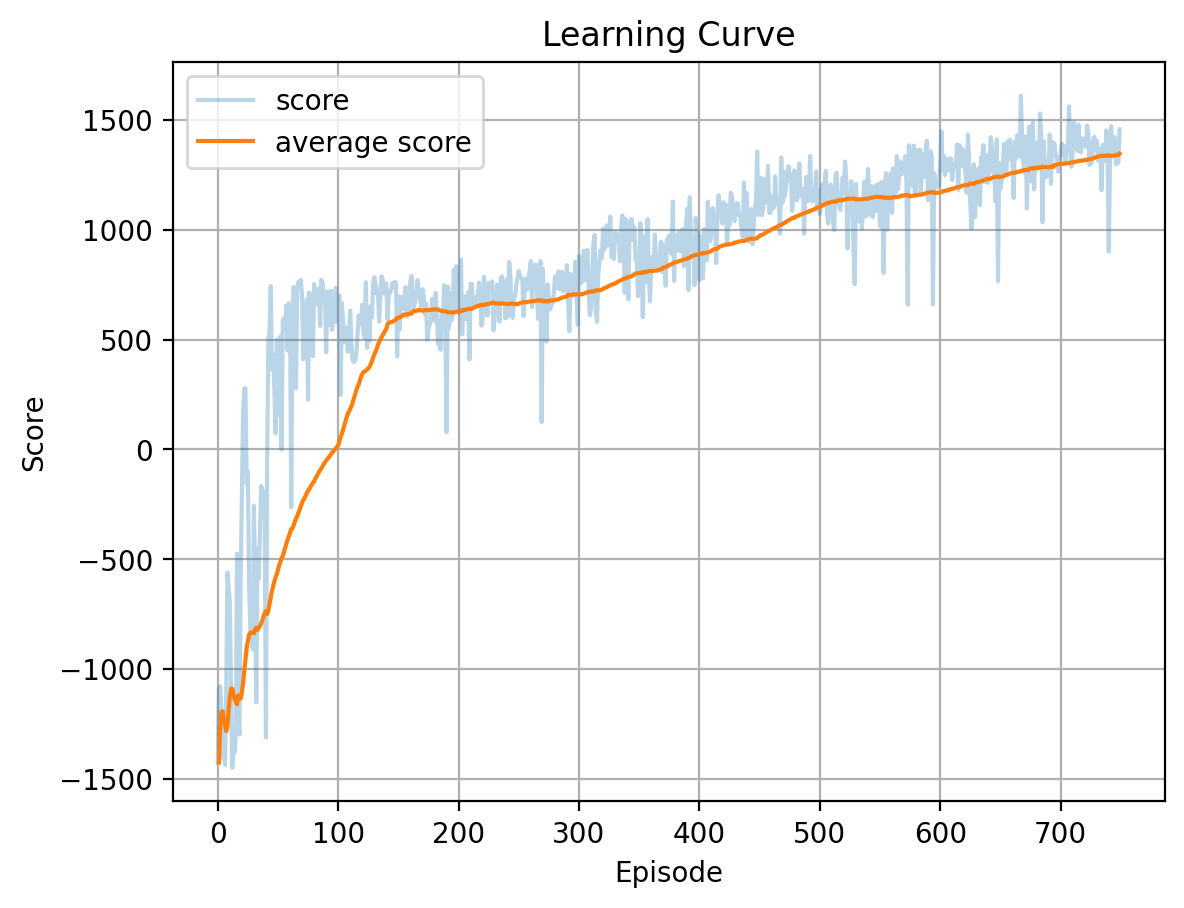

In [10]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta,
              state_dims=env.observation_space.shape[0],
              action_dims=env.action_space.shape[0],
              max_action=env.action_space.high[0],
              fc1_dim=fc1_dim, fc2_dim=fc2_dim,
              memory_size=memory_size, batch_size=batch_size,
              tau=tau, update_period=update_period,
              reward_scale=reward_scale, warmup=warmup,
              reparam_noise_lim=reparam_noise_lim,
              name='SAC_' + env_name, ckpt_dir=dir)


scores = []
best_score = -np.inf

for game in trange(n_games):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

    scores.append(score)
    avg_score = np.mean(scores[-100:])

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

    if avg_score > best_score:
        best_score = avg_score
        agent.save_model()

env.close()

plot_learning_curve(np.array(scores), agent.full_path)

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [8]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)